# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [ ]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import heapq

%matplotlib inline

In [ ]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map = imageio.imread('./map/vivocity_freespace.png')
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start': [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],  # Garrett Popcorn
             'store': [20, 705],    # DJI Store
             'movie': [940, 545],   # Golden Village
             'food': [535, 800],    # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

## Barrier expansion

In [ ]:
length, height = grid_map.shape

# identify whether the grid has been expanded to avoid over expansion
flag = {}
for i in range(length):
    for j in range(height):
        flag[(i,j)] = 0

# go over every grid of the map
for i in range(length):
    for j in range(height):
        if grid_map[i][j] == 255:
            continue
        elif flag[(i,j)] == 1:
            continue
        # expand the barrier with four directions
        else:
            if i-1 >= 0 and grid_map[i-1][j] == 255:
                grid_map[i-1][j] = 0
                flag[(i-1,j)] = 1
            if i+1 < 1000 and grid_map[i+1][j] == 255:
                grid_map[i+1][j] = 0
                flag[(i+1,j)] = 1
            if j-1 >= 0 and grid_map[i][j-1] == 255:
                grid_map[i][j-1] = 0
                flag[(i,j-1)] = 1
            if j+1 < 1000 and grid_map[i][j+1] == 255:
                grid_map[i][j+1] = 0
                flag[(i,j+1)] = 1


# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

## Task 1 Astar algorithm

In [ ]:
class Node:
    def __init__(self, x, y, cost):
        self.x = x
        self.y = y
        self.g = float('inf')
        self.h = float('inf')
        self.f = float('inf')
        self.parent = None
        self.cost = cost

# Manhattan distance
# def heuristic(node, goal):
#     return 0.2*(abs(node.x - goal.x) + abs(node.y - goal.y))

# Euclidean distance
# def heuristic(node, goal):
#     return 0.2*np.sqrt((node.x - goal.x)**2 + (node.y - goal.y)**2)

# Chebyshev distance
def heuristic(node, goal):
    return max(abs(node.x - goal.x), abs(node.y - goal.y))

def get_neighbors(node, grid):
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            # Skip node itself
            if dx == 0 and dy == 0:
                continue
            # Calculate coordinates of neighbor node
            x = node.x + dx
            y = node.y + dy
            # Check if neighbor node is within the bounds of the grid and check if neighbor node is an obstacle
            if x < 0 or x >= len(grid) or y < 0 or y >= len(grid[0]) or grid[x][y] == 0 :
                continue
            # Calculate cost to reach neighbor node
            if dx == 0 or dy == 0:
                cost = 0.2
            else:
                cost = 0.282
            # Create neighbor node and add to list of neighbors
            neighbor = Node(x, y, cost)
            neighbors.append(neighbor)
    return neighbors



def astar(grid, start_node, goal_node):
    
    # start node initialization
    open_list = [start_node]
    closed_list = set()
    start_node.g = 0
    start_node.h = heuristic(start_node, goal_node)
    start_node.f = start_node.g + start_node.h
    current_node = start_node

    while open_list:
        # find the node with min f value to do the next search
        current_node = min(open_list, key = lambda x: x.f)

        # search the goal and get the path and calculate the distance
        if current_node.x == goal_node.x and current_node.y == goal_node.y:
            path = set()
            total_distance = 0
            while current_node:
                path.add((current_node.x, current_node.y))

                total_distance += current_node.cost
                current_node = current_node.parent
            return path, total_distance
        
        # add the node to the closed_list if it has been visited
        closed_list.add((current_node.x,current_node.y))
        # print("close list :",current_node.x, current_node.y)
        
        # remove the node of open_list 
        open_list.remove(current_node)

        # find the 8-connectivity neighbors
        neighbors = get_neighbors(current_node, grid)
        for neighbor in neighbors:
            # if the neighbor is a barrier or has been visited, loop for next neighbor
            if grid[neighbor.x][neighbor.y] == 0:
                continue
            if (neighbor.x, neighbor.y)  in closed_list:
                continue
            
            # calculate the value g with adding the cost
            new_g = current_node.g + neighbor.cost
            if neighbor not in open_list or new_g < neighbor.g:
                neighbor.g = new_g
                neighbor.h = heuristic(neighbor, goal_node)
                neighbor.f = neighbor.g + neighbor.h

                # record the parent node
                neighbor.parent = current_node

                # check whether the node is in the open list, if not ,add it to the open_list(set)
                FLAG = 0
                for node in open_list:
                    if neighbor.x == node.x and neighbor.y == node.y:
                        FLAG = 1
                        break
                if FLAG == 0:
                    open_list.append(neighbor)


# Call astar function and retrieve path and distance
grid = np.transpose(grid_map)
my_route = {}
i = 0

# print out the path and distance
for key_start, pos_start in locations.items():
    for key_goal, pos_goal in locations.items():
        start_node = Node(pos_start[0], pos_start[1], 0)
        goal_node = Node(pos_goal[0], pos_goal[1], 0)
        path, total_distance = astar(grid = grid, start_node=start_node, goal_node=goal_node)
        # Print path and total distance
        print("Path from",key_start, "to", key_goal, ":", path)
        print("Total distance: ", total_distance)
        my_route[i] = path
        i += 1


## Plot astar routes

In [ ]:
def plot_route():
    i = 0
    # for j in [1,2,3,4,7,8,9,13,14,19]: # lower part
    # for j in [5,10,15,20,11,16,21,17,22,23]:  # upper part
    
    
    # # best route
    # for j in [1,2,3,4,11,16,9,17,14,19]: # Manhattan distance
    # for j in [1,2,3,20,11,8,9,17,14,23]: # Euclidean distance
    for j in [5,10,15,20,7,8,21,17,14,23]: # Chebyshev distance
        for route in my_route[j]: 
            x_pos, y_pos = route
            plt.plot(x_pos, y_pos, marker="o", markersize=1, markeredgecolor = route_color[i])
        i += 1
    return

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return


route_color = ["red", "blue", "green", "purple", "orange", "pink", "black", "gray", "brown", "cyan"]
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plot_route()
plt.subplot(1,2,2)
plt.imshow(grid_map, cmap='gray')
plot_locations(locations, color='cyan')
plot_route()
plt.show()


## Dijkstra Algorithm

In [18]:
class Node:
    def __init__(self, x, y, cost):
        self.x = x
        self.y = y
        self.g = float('inf')
        self.h = float('inf')
        self.parent = None
        self.cost = cost

def get_neighbors(node, grid):
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            # Skip node itself
            if dx == 0 and dy == 0:
                continue
            # Calculate coordinates of neighbor node
            x = node.x + dx
            y = node.y + dy
            # Check if neighbor node is within the bounds of the grid and check if neighbor node is an obstacle
            if x < 0 or x >= len(grid) or y < 0 or y >= len(grid[0]) or grid[x][y] == 0 :
                continue
            # Calculate cost to reach neighbor node
            if dx == 0 or dy == 0:
                cost = 0.2
            else:
                cost = 0.282
            # Create neighbor node and add to list of neighbors
            neighbor = Node(x, y, cost)
            neighbors.append(neighbor)
    return neighbors



def astar(grid, start_node, goal_node):
    
    # initialize the start node
    open_list = [start_node]
    closed_list = set()
    start_node.g = 0
    
    current_node = start_node

    while open_list:
        # find the node with min g value to do the next search
        current_node = min(open_list, key = lambda x: x.g)

        # search the goal and get the path and calculate the distance
        if current_node.x == goal_node.x and current_node.y == goal_node.y:
            path = set()
            total_distance = 0
            while current_node:
                path.add((current_node.x, current_node.y))

                total_distance += current_node.cost
                current_node = current_node.parent
            return path, total_distance
        
        # add the node to the closed_list if it has been visited
        closed_list.add((current_node.x,current_node.y))
        # print("close list :",current_node.x, current_node.y)

        # remove the node of open_list 
        open_list.remove(current_node)
        
        # find the 8-connectivity neighbor
        neighbors = get_neighbors(current_node, grid)
        for neighbor in neighbors:
            flag = 0
            
            # if the neighbor is a barrier or has been visited, loop for next neighbor
            if grid[neighbor.x][neighbor.y] == 0:
                continue
            if (neighbor.x, neighbor.y)  in closed_list:
                continue
        
            # calculate the value g with adding the cost
            new_g = current_node.g + neighbor.cost
            if neighbor not in open_list or new_g < neighbor.g:
                neighbor.g = new_g
                neighbor.parent = current_node
                
                # check whether the node is in the open list, if not ,add it to the open_list(set)
                flag = 0
                for node in open_list:
                    if neighbor.x == node.x and neighbor.y == node.y:
                        flag = 1
                        break
                if flag == 0:
                    open_list.append(neighbor)


# Call astar function and retrieve path and distance
grid = np.transpose(grid_map)
my_route = {}
i = 0
for key_start, pos_start in locations.items():
    for key_goal, pos_goal in locations.items():
        start_node = Node(pos_start[0], pos_start[1], 0)
        goal_node = Node(pos_goal[0], pos_goal[1], 0)
        path, total_distance = astar(grid = grid, start_node=start_node, goal_node=goal_node)
        # Print path and total distance
        print("Path from",key_start, "to", key_goal, ":", path)
        print("Total distance: ", total_distance)
        my_route[i] = path
        i += 1

Path from start to start : {(345, 95)}
Total distance:  0
Path from start to snacks : {(595, 489), (391, 277), (606, 480), (575, 420), (482, 469), (517, 472), (368, 119), (604, 482), (391, 307), (539, 479), (589, 489), (512, 471), (391, 320), (600, 486), (455, 379), (349, 95), (584, 489), (543, 409), (371, 141), (506, 397), (451, 378), (599, 487), (354, 100), (547, 482), (391, 239), (371, 179), (539, 408), (434, 369), (391, 274), (591, 427), (473, 385), (522, 474), (391, 296), (535, 478), (478, 469), (496, 393), (519, 401), (605, 441), (590, 489), (388, 226), (371, 146), (612, 454), (350, 96), (371, 184), (598, 488), (471, 385), (391, 267), (403, 340), (537, 407), (382, 204), (391, 289), (397, 334), (503, 470), (483, 469), (465, 383), (382, 214), (391, 319), (588, 489), (431, 367), (527, 475), (406, 343), (371, 155), (570, 418), (612, 461), (392, 329), (482, 388), (611, 475), (438, 372), (435, 370), (391, 256), (462, 382), (404, 341), (391, 251), (371, 167), (377, 199), (391, 286), (48

## Plot Dijkstra routes

In [ ]:
def plot_route():
    i = 0
    # for j in [1,2,3,4,7,8,9,13,14,19]:  #lower part and best route
    for j in [5,10,15,20,11,16,21,17,22,23]: #upper part
        for route in my_route[j]: 
            x_pos, y_pos = route
            plt.plot(x_pos, y_pos, marker="o", markersize=1, markeredgecolor = route_color[i])
        i += 1
    return

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

route_color = ["red", "blue", "green", "purple", "orange", "pink", "black", "gray", "brown", "cyan"]
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plot_route()
plt.subplot(1,2,2)
plt.imshow(grid_map, cmap='gray')
plot_locations(locations, color='cyan')
plot_route()
plt.show()

## Greedy Best First Search Algrithm

In [ ]:
class Node:
    def __init__(self, x, y, cost):
        self.x = x
        self.y = y
        self.h = float('inf')
        self.parent = None
        self.cost = cost

def heuristic(node, goal):
    return 0.2*(abs(node.x - goal.x) + abs(node.y - goal.y))

def get_neighbors(node, grid):
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            # Skip node itself
            if dx == 0 and dy == 0:
                continue
            # Calculate coordinates of neighbor node
            x = node.x + dx
            y = node.y + dy
            # Check if neighbor node is within the bounds of the grid and check if neighbor node is an obstacle
            if x < 0 or x >= len(grid) or y < 0 or y >= len(grid[0]) or grid[x][y] == 0 :
                continue
            # Calculate cost to reach neighbor node
            if dx == 0 or dy == 0:
                cost = 0.2
            else:
                cost = 0.282
            # Create neighbor node and add to list of neighbors
            neighbor = Node(x, y, cost)
            neighbors.append(neighbor)
    return neighbors



def astar(grid, start_node, goal_node):
    
    # initialize the start node
    open_list = [start_node]
    closed_list = set()
    start_node.h = heuristic(start_node, goal_node)
    current_node = start_node

    while open_list:
        # find the node with min h value to do the next search
        current_node = min(open_list, key = lambda x: x.h)

        # search the goal and get the path and calculate the distance
        if current_node.x == goal_node.x and current_node.y == goal_node.y:
            path = set()
            total_distance = 0
            while current_node:
                path.add((current_node.x, current_node.y))

                total_distance += current_node.cost
                current_node = current_node.parent
            return path, total_distance
        
        # add the node to the closed_list if it has been visited
        closed_list.add((current_node.x,current_node.y))
        # print("close list :",current_node.x, current_node.y)

        # remove the node of open_list
        open_list.remove(current_node)

        # find the 8-connectivity neighbor
        neighbors = get_neighbors(current_node, grid)
        for neighbor in neighbors:
            # if the neighbor is a barrier or has been visited, loop for next neighbor
            if grid[neighbor.x][neighbor.y] == 0:
                continue
            if (neighbor.x, neighbor.y)  in closed_list:
                continue
        
            if neighbor not in open_list :
                neighbor.h = heuristic(neighbor, goal_node)
                neighbor.parent = current_node
                appe = 0

                # check whether the node is in the open list, if not ,add it to the open_list(set)
                for node in open_list:
                    if neighbor.x == node.x and neighbor.y == node.y:
                        appe = 1
                        break
                if appe == 0:
                    open_list.append(neighbor)


# Call astar function and retrieve path and distance
grid = np.transpose(grid_map)
my_route = {}
i = 0
for key_start, pos_start in locations.items():
    for key_goal, pos_goal in locations.items():
        start_node = Node(pos_start[0], pos_start[1], 0)
        goal_node = Node(pos_goal[0], pos_goal[1], 0)
        path, total_distance = astar(grid = grid, start_node=start_node, goal_node=goal_node)
        # Print path and total distance
        print("Path from",key_start, "to", key_goal, ":", path)
        print("Total distance: ", total_distance)
        my_route[i] = path
        i += 1

## Plot GBFS routes 

In [ ]:
def plot_route():
    i = 0
    # for j in [1,2,3,4,7,8,9,13,14,19]: #lower part 
    # for j in [5,10,15,20,11,16,21,17,22,23]: #upper part
     
    for j in [5,2,15,4,11,16,9,17,14,19]: # best route
        for route in my_route[j]: 
            x_pos, y_pos = route
            plt.plot(x_pos, y_pos, marker="o", markersize=1, markeredgecolor = route_color[i])
        i += 1
    return

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

route_color = ["red", "blue", "green", "purple", "orange", "pink", "black", "gray", "brown", "cyan"]
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plot_route()
plt.subplot(1,2,2)
plt.imshow(grid_map, cmap='gray')
plot_locations(locations, color='cyan')
plot_route()
plt.show()

## Task 3: DFS

In [19]:
INF = 0X7FFFFFFFF
# distance calculated by dijkstra
dis = np.array([[0,      141.85, 154.55, 178.44, 222.11],
                [141.85, 0,      114.41, 107.15, 132.57],
                [154.55, 114.41, 0,      209.13, 110.79],
                [178.44, 107.15, 209.13, 0,      113.47],
                [222.11, 132.57, 110.79, 113.47, 0]])

ans = INF
loc = set([1,2,3,4])
path = [0,0,0,0,0]

# choose one node in (1,2,3,4)
for i in range (1,5):
    route = 0
    loc.remove(i)
    route += dis[0,i]
    # choose one node in the rest 3 locations
    for j in loc:
        route += dis[i,j]
        loc.remove(j)
        # choose one node in the rest 2 locations
        for k in loc:
            route += dis[j,k]
            loc.remove(k)

            # get the last location 
            ele = loc.pop()

            # calculate the route distance
            route += dis[k,ele]
            route += dis[ele,0]

            # record the best route
            if ans > route:
                path[4] = ele
                path[3] = k
                path[2] = j
                path[1] = i
                ans = route
            route -= dis[ele,0]
            route -= dis[k,ele]
            loc.add(ele)
            loc.add(k)
            route -= dis[j,k]
        loc.add(j)
        route -= dis[i,j]  
    loc.add(i)
    route - dis[0,i] 

loc_name = ["Start","Snacks","Store","Movie","Food"]
print(ans) 
for i in range(len(path)):
    print(loc_name[path[i]],"--> ",end='')
print("Start")  

627.81
Start --> Store --> Food --> Movie --> Snacks --> Start


## Plot route of DFS

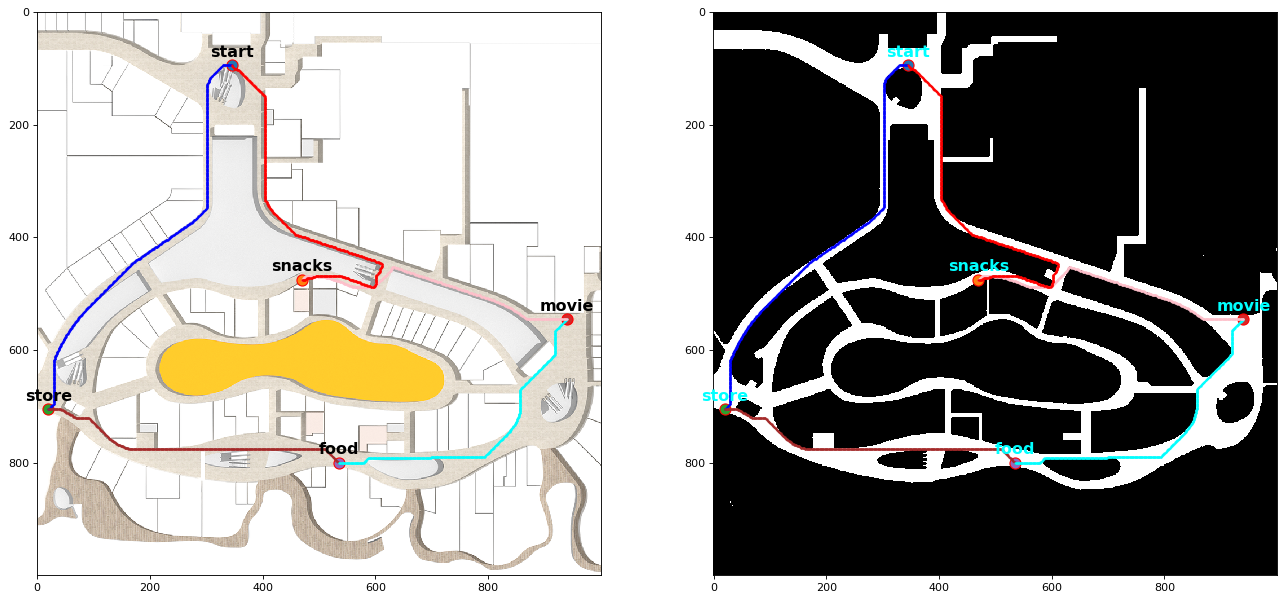

In [22]:
def plot_route():
    i = 0
    for j in [2,14,23,16,5]: 
        for route in my_route[j]: 
            x_pos, y_pos = route
            plt.plot(x_pos, y_pos, marker="o", markersize=1, markeredgecolor = route_color[i])
        i += 1
    return

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

route_color = ["blue", "brown", "cyan", "pink", "red"]
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plot_route()
plt.subplot(1,2,2)
plt.imshow(grid_map, cmap='gray')
plot_locations(locations, color='cyan')
plot_route()
plt.show()

## Task 3 : Dynamic Programming

In [24]:
INF = 0X7FFFFFFFF

# distance calculated by dijkstra
dis = np.array([[0,      141.85, 154.55, 178.44, 222.11],
                [141.85, 0,      114.41, 107.15, 132.57],
                [154.55, 114.41, 0,      209.13, 110.79],
                [178.44, 107.15, 209.13, 0,      113.47],
                [222.11, 132.57, 110.79, 113.47, 0]])

# S means the set of which location is included
# eg: s = 0 --> empty set;
#     s = 1 --> binary:1 --> {0}
#     s = 2 --> binary:10 --> {1}
#     s = 3 --> binary:11 --> {0,1}
#     s = 31 --> binary:11111 --> {0,1,2,3,4}
S = (1<<5)-1

# f[i][j]: The shortest distance ends at location j and pass by all the locations in set i
f = np.zeros((S+1, 5), dtype=float)
pioneer = {}
for i in range (S+1):
    for j in range (5):
        f[i][j] = INF

# we should start from location 
# all the sets calculated must at least include location 0
f[1][0] = 0
for i in range (1,S+1):
    if i == 9:
        a = 1
    for j in range(5):
        # some f[i][j] are meaningless such as{4} 10000
        if f[i][j] == INF: 
            continue
        # check whether 5 locations are included in the set
        for k in range (5): 
            if (i>>k) & 1:
                continue
            # if location k is not in the set, add it to the set and check the shortest distance for update
            if f[i+(1<<k)][k] > (f[i][j] + dis[j][k]):
                pioneer[(i+(1<<k),k)] = (i,j)
                f[i+(1<<k)][k] = f[i][j] + dis[j][k]
            
        # # print the matrix for testing
        # print("Matrix:",i,j)
        # for m in range(5):
        #     for n in range (S+1):
        #         if f[n][m] == INF:
        #             print("INF    ", end='')
        #         else:
        #             print(f[n][m]," ", end='')
        #     print('\n')

ans = INF

# calculate the shortest distance and get the last location
# the set {0,1,2,3,4} means pass 0,1,2,3,4 and get the shortest to return to the start
loc = 0
for i in range (5):
    if f[S][i] != INF:
        if ans > f[S][i] + dis[i][0]:
            ans = f[S][i] + dis[i][0]
            loc = i
print("The distance of shortest route: ", ans)


# find the route
plan = []
print("route: ")
s = S
while s:
    plan.append(loc)
    if len(plan) != 5:
        pio = pioneer[(s,loc)]
        s = pio[0]
        loc = pio[1]
    else:
        break

loc_name = ["Start","Snacks","Store","Movie","Food"]
while plan: 
    print(loc_name[plan.pop()],"--> ",end='')   
print("Start")  

The distance of shortest route:  627.8100000000001
route: 
Start --> Store --> Food --> Movie --> Snacks --> Start


## Plot Route of DP

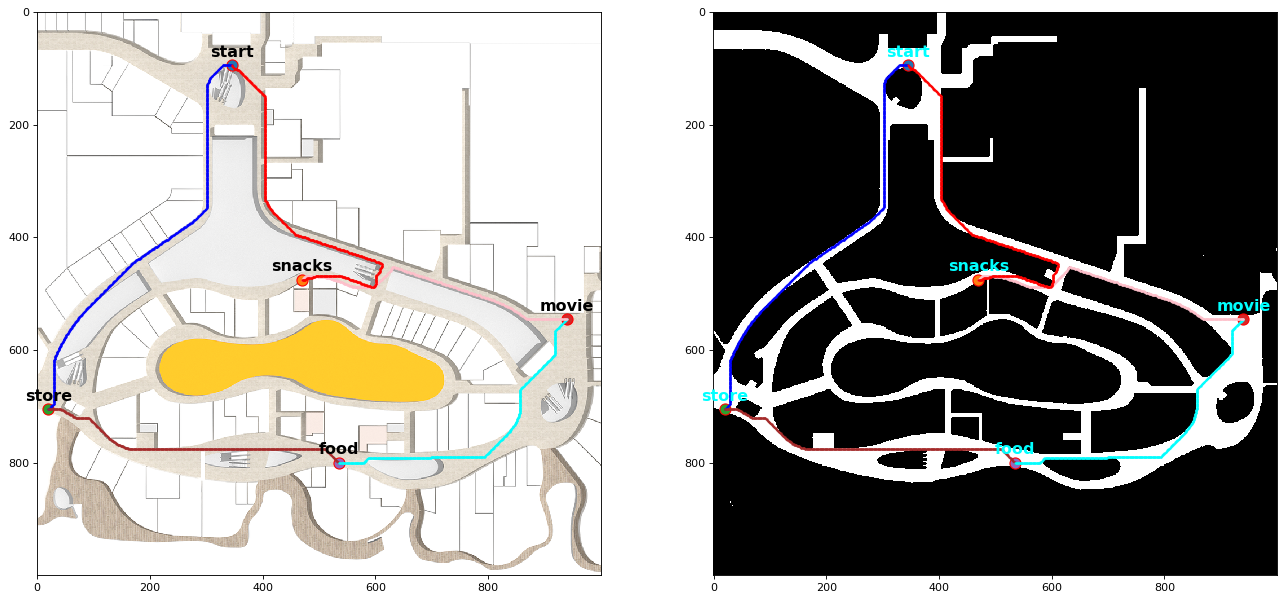

In [25]:
def plot_route():
    i = 0
    for j in [2,14,23,16,5]: #upper part
        for route in my_route[j]: 
            x_pos, y_pos = route
            plt.plot(x_pos, y_pos, marker="o", markersize=1, markeredgecolor = route_color[i])
        i += 1
    return

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

route_color = ["blue", "brown", "cyan", "pink", "red"]
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plot_route()
plt.subplot(1,2,2)
plt.imshow(grid_map, cmap='gray')
plot_locations(locations, color='cyan')
plot_route()
plt.show()